In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import (
    roc_curve,
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)
from plot_metric.functions import BinaryClassification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import PowerTransformer

# Set visualization style
sns.set_style("whitegrid")

# Increase the maximum number of displayed rows
pd.options.display.max_rows = 200

def Find_Optimal_Cutoff(target, predicted):
    '''
    Find data-driven cut-off for classification
    
    Cut-off is determined using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    target : array, shape = [n_samples]
        True binary labels.
        
    predicted : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        "decision_function" on some classifiers).
        
    References
    ----------
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(target, predicted)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def train_model(data_final):
    # List of features to use for training
    feature_list_for_training = [
        'sex_M',
        'age_18-29',  'age_40-49', 'age_50-59', 'age_60+',
        'substance', 'mood', 'anxiety', 'psychotic', 'cognitive', 'otherpsych', 'selfharm',
        'visit_emr_MH_non_elect', 'visit_emr_NonMH', 'visit_emr_visit',
        'visit_hosp_visit', 'visit_hospitalized_MH', 'visit_hospitalized_NonMH',
        'visit_family_gp', 'visit_im', 'visit_neurology', 'visit_other', 'visit_pharmacy', 'visit_psychiatry',
        'EX_CHF', 'EX_Arrhy', 'EX_VD', 'EX_PCD', 'EX_PVD', 'EX_HPTN_UC',
        'EX_HPTN_C', 'EX_Para', 'Ex_OthND', 'Ex_COPD', 'Ex_Diab_UC',
        'Ex_Diab_C', 'Ex_Hptothy', 'Ex_RF', 'Ex_LD', 'Ex_PUD_NB', 'Ex_HIV',
        'Ex_Lymp', 'Ex_METS', 'Ex_Tumor', 'Ex_Rheum_A', 'Ex_Coag', 'Ex_Obesity',
        'Ex_WL', 'Ex_Fluid', 'Ex_BLA', 'Ex_DA', 'Ex_Alcohol', 'Ex_Drug',
        'Ex_Psycho', 'Ex_Dep', 'Ex_Stroke', 'Ex_Dyslipid', 'Ex_Sleep', 'Ex_IHD',
        'EX_Fall', 'EX_Urinary', 'EX_Visual', 'EX_Hearing', 'EX_Tobacco',
        'EX_Delirium', 'Ex_MS', 'EX_parkinsons',
    ]

    # Separate the features for training
    X = data_final[feature_list_for_training]
    
    # Separate the labels for training
    y = data_final['police_interaction_followup']

    # Add the constant to the X features
    X = sm.add_constant(X)

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Fit the logistic regression model
    log_reg = sm.Logit(y_train, X_train).fit()

    # Predict probabilities for the test set
    yhat = log_reg.predict(X_test)

    # Find optimal probability threshold by using yhat as a continuous measure
    threshold = Find_Optimal_Cutoff(y_test, yhat)

    # Find predictions by applying the threshold to yhat
    prediction = pd.Series(yhat).map(lambda x: 1 if x > threshold else 0)

    # Calculate evaluation metrics
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    sensitivity = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)

    # Create a DataFrame to store the evaluation metrics
    df_results = pd.DataFrame((round(f1, 2), round(roc_auc, 2), round(sensitivity, 2), round(precision, 2)))
    df_results = df_results.T

    return df_results, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, y



/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Display unique values of the 'police_interaction_followup' column
[0 1]


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


         Current function value: 0.017506
         Iterations: 35
Confusion Matrix:
 [[20006  3634]
 [   15    60]]
Test accuracy = 0.8461311406282943
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     23640
           1       0.02      0.80      0.03        75

    accuracy                           0.85     23715
   macro avg       0.51      0.82      0.47     23715
weighted avg       1.00      0.85      0.91     23715

F1 Score: 0.03183868400106129
AUC: 0.82%


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


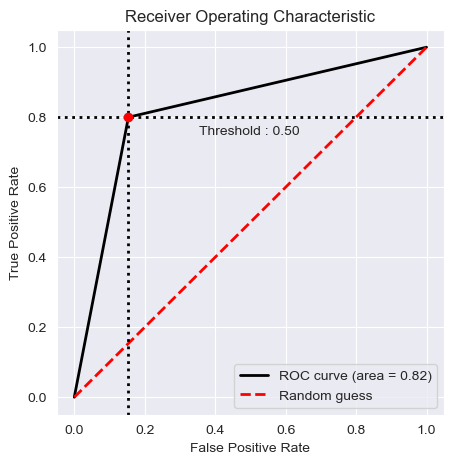

In [3]:

# Read the data
data_final = pd.read_hdf('data/df_subjects_retro_policing_preproc.h5', 'df_subjects_retro_policing_preproc')

print("Display unique values of the 'police_interaction_followup' column")
print(data_final['police_interaction_followup'].unique())

# Convert 'age' column to integer
data_final['age'] = data_final['age'].map(lambda x: int(x))

# Call the train_model function and store the results
df_results, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, y = train_model(data_final)

# Confusion matrix for the test dataset
cm = confusion_matrix(y_test, prediction)
print("Confusion Matrix:\n", cm)

# Accuracy score of the model
print("Test accuracy =", accuracy_score(y_test, prediction))

# Classification report
print(classification_report(y_test, prediction))

# F1 score
print("F1 Score: {}".format(f1_score(y_test, prediction)))

# ROC AUC score
roc_auc = roc_auc_score(y_test, prediction)
print("AUC: %.2f" % roc_auc + "%")

# Visualisation with plot_metric
bc = BinaryClassification(y_test, prediction, labels=["Class 1", "Class 2"])

# Plot ROC curve
plt.figure(figsize=(5, 5))
bc.plot_roc_curve()
plt.show()


# Oddsratio

In [18]:
result = log_reg

# Calculate the odds ratios and confidence intervals
df_results = np.round(np.exp(result.conf_int()), 2)
df_results.columns = ['2.5%', '97.5%']
df_results['OR'] = pd.DataFrame(np.exp(result.params))
df_results['OR'] = df_results['OR'].map(lambda x: np.round(x, 2))

# Calculate the p-values
df_results['P_value'] = np.round(result.pvalues.values, 2)

# Format the confidence intervals, rounding to two decimal places
df_results['2.5%'] = df_results['2.5%'].map(lambda x: np.round(x, 2))
df_results['97.5%'] = df_results['97.5%'].map(lambda x: '{:.2f}'.format(float(x)))



/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [22]:
df_results[['OR','2.5%', '97.5%', 'P_value']][:30].sort_values("OR",ascending=False)

,OR,2.5%,97.5%,P_value
substance,2.83,2.18,3.69,0.00
visit_emr_NonMH,2.68,1.85,3.88,0.00
sex_M,2.52,2.10,3.02,0.00
visit_pharmacy,2.39,0.25,22.48,0.45
visit_emr_MH_non_elect,2.06,1.66,2.54,0.00
EX_VD,1.97,1.01,3.85,0.05
psychotic,1.73,1.26,2.36,0.00
mood,1.60,1.26,2.03,0.00
visit_psychiatry,1.49,1.19,1.85,0.00
selfharm,1.29,0.88,1.88,0.19
